In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN 
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from hausdorff import hausdorff_distance

from Bio.Cluster import kmedoids

from itertools import combinations

In [2]:
POINTS_NUM_PER_TR = 500

df = pd.read_csv('../data/all.csv')

NUM_TR = int(len(df)/POINTS_NUM_PER_TR)

In [3]:
df

,person_id,x,y
0,0,46.619,-22.899
1,0,46.590,-22.877
2,0,46.528,-22.829
3,0,46.483,-22.810
4,0,46.460,-22.821
...,...,...,...
483995,4932,13.653,-11.913
483996,4932,13.806,-11.856
483997,4932,13.887,-11.821
483998,4932,13.904,-11.803


In [3]:
NUM_TR

968

In [4]:
def df2array(df):
    # 将数据以 ndarray 的形式读入内存
    # [[x1,x2,...,x500,y1,y2,...,y500],[],...]
    i = 0
    data = np.array([])
    while i <= len(df)-1:
        arr_x = np.array(df['x'][i:i+POINTS_NUM_PER_TR])
        arr_y = np.array(df['y'][i:i+POINTS_NUM_PER_TR])
        arr = np.append(arr_x,arr_y)
        if len(data)==0:
            data = np.array([arr])
        else:
            data = np.append(data,[arr],axis=0)
        i+=POINTS_NUM_PER_TR
    return data

In [5]:
DATA = df2array(df)

In [6]:
DATA

array([[ 46.619,  46.59 ,  46.528, ..., -16.763, -16.738, -16.701],
       [ 42.603,  42.579,  42.515, ...,   5.021,   5.053,   5.13 ],
       [-24.227, -24.211, -24.168, ...,  19.123,  19.187,  19.264],
       ...,
       [-16.401, -16.411, -16.423, ..., -13.48 , -13.545, -13.602],
       [ 45.387,  45.359,  45.263, ...,   2.25 ,   2.221,   2.173],
       [ 14.487,  14.497,  14.524, ..., -11.821, -11.803, -11.772]])

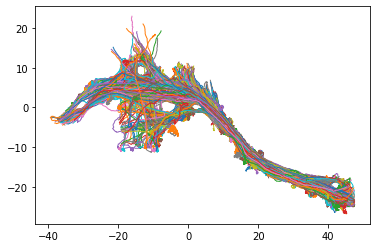

In [6]:
for i in range(len(DATA)):
    x = DATA[i][:POINTS_NUM_PER_TR]
    y = DATA[i][POINTS_NUM_PER_TR:]
    plt.plot(x,y,linewidth=1)
plt.show()

In [8]:
def discretization(data):
    
    # 网格坐标化
    data = np.round(data)
    tr_point = [    [  (data[j][i],data[j][i+POINTS_NUM_PER_TR])    for i in range(POINTS_NUM_PER_TR)]     
                           for j in range(len(data))]
    
    
    # 去掉连续落在同一区间上的点
    for i in range(len(tr_point)):
        tmp = []
        l = tr_point[i].copy()
        for j in range(POINTS_NUM_PER_TR-1):
            if l[j] == l[j+1]:
                tmp.append(j)
        tr_point[i] = [l[i] for i in range(POINTS_NUM_PER_TR) if i not in tmp]
        
    # 防止出现跨越的点
    for i in range(len(tr_point)):
        tmp = tr_point[i].copy()  # [(),(),...,()]
        count = 0 # 添加的点造成的偏移
        for j in range(len(tmp) - 1):
            now_p = tmp[j]
            next_p = tmp[j + 1]
            if not(tr_point[i][j + count] == now_p and tr_point[i][j + count + 1] == next_p):
                print('WRONGGGGG: ',now_p,next_p,tr_point[i][j + count],tr_point[i][j + count],)
                break
            if now_p[0] == next_p[0] and abs(now_p[1] - next_p[1]) == 1:
                continue
            elif abs(now_p[0] - next_p[0]) == 1 and now_p[1] == next_p[1]:
                continue   
            else:
                # print(now_p,next_p)
                delta_x = int(abs(now_p[0] - next_p[0]))
                delta_y = int(abs(now_p[1] - next_p[1]))
                if delta_x == 0:
                    step = (next_p[1] - now_p[1]) / delta_y
                    for k in range(1,delta_y,1):
                        tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                    count = count + delta_y - 1
                    continue
                elif delta_y == 0:
                    step = (next_p[0] - now_p[0])/delta_x
                    for k in range(1,delta_x,1):
                        tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                    count = count + delta_x - 1
                    continue
                else:
                    step_x = (next_p[0] - now_p[0])/delta_x
                    step_y = (next_p[1] - now_p[1]) / delta_y
                    k = 1
                    while delta_x != 0 and delta_y != 0:
                        tr_point[i].insert(j + count + 1,(now_p[0] + k * step_x,now_p[1]))
                        tr_point[i].insert(j + count + 2,(now_p[0] + k * step_x,now_p[1] + k * step_y))
                        count = count + 2
                        k = k + 1
                        delta_x = delta_x - 1
                        delta_y = delta_y - 1
                    if delta_x == 0 and delta_y == 0:
                        tr_point[i].pop(j + count)
                        count = count - 1
                    elif delta_x == 0:
                        step = (next_p[1] - now_p[1]) / delta_y
                        for k in range(1,delta_y,1):
                            tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                        count = count + delta_y - 1
                        continue
                    elif delta_y == 0:
                        step = (next_p[0] - now_p[0])/delta_x
                        for k in range(1,delta_x,1):
                            tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                        count = count + delta_x - 1
                        continue
                        
    return tr_point

In [9]:
DISC_DATA = discretization(DATA)

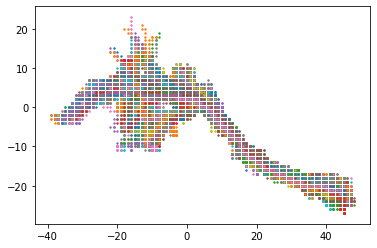

In [10]:
for i in  DISC_DATA:
    x = [point[0] for point in i]
    y = [point[1] for point in i]
    plt.scatter(x,y,2)
plt.show()

In [11]:
def dist(a,b):
    
    return hausdorff_distance(a,b)

In [12]:
def distMatrix(data):
    length = len(data)
    mat = [[]]
    for i in range(1,length):
        tmp = []
        for j in range(i):
            tmp.append(dist(np.array(data[i]),np.array(data[j])))
        mat.append(tmp) 
    return mat

In [25]:
MAT = distMatrix(DISC_DATA)

In [26]:
#  clusterid 中的类号是指的是代表聚类中心的元素号。
def cluster(data,K,mat):
    clusterid, error, nfound = kmedoids(mat,K,npass = 10)
    return clusterid

In [14]:
def cost(data,labels):
    loss = 0
    for i in range(len(data)):
        loss = loss + dist(np.array(data[i]),np.array(data[labels[i]]))
    loss = loss / len(data)
    return loss

In [32]:
def chooseK(data,K,mat):
    x = np.arange(3,K+1)
    y = np.zeros(len(x))
    for k in range(3,K+1):
        labels = cluster(data,k,mat)
        y[k-3] = cost(data, labels)
    plt.plot(x,y)
    plt.show()

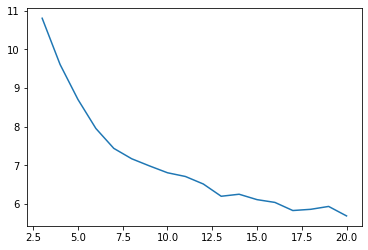

In [33]:
chooseK(DISC_DATA,20,MAT)

In [46]:
baseline = cluster(DISC_DATA,7,MAT)
baseline

array([733, 504, 921, 733, 227, 921, 246, 504, 246, 921, 886, 921, 733,
       886, 227, 227, 504, 921, 246, 227, 227, 921, 733, 886, 733, 886,
       921, 246, 921, 921, 886, 227, 227, 246, 921, 504, 227, 227, 733,
       227, 227, 227, 227, 504, 227, 553, 504, 227, 733, 227, 886, 553,
       504, 246, 553, 886, 227, 504, 553, 227, 227, 246, 921, 227, 227,
       227, 504, 553, 886, 921, 504, 886, 553, 227, 921, 504, 553, 227,
       886, 504, 504, 504, 886, 504, 504, 733, 504, 733, 733, 553, 553,
       733, 733, 921, 921, 886, 553, 921, 227, 227, 246, 553, 733, 227,
       227, 886, 553, 553, 553, 227, 886, 733, 733, 733, 733, 227, 504,
       227, 246, 227, 504, 733, 921, 886, 553, 227, 227, 921, 921, 553,
       504, 921, 733, 504, 553, 246, 504, 227, 733, 227, 227, 886, 921,
       553, 246, 227, 553, 921, 227, 886, 227, 553, 504, 504, 553, 504,
       553, 886, 921, 504, 553, 227, 553, 553, 553, 553, 227, 553, 921,
       553, 227, 504, 504, 504, 921, 553, 227, 921, 227, 921, 22

In [23]:
def RI(a,b):
    ss = 0
    dd = 0
    sum = 0
    for com in combinations(range(len(a)),2):
        sum = sum + 1
        if (a[com[0]] == a[com[1]]) and (b[com[0]] == b[com[1]]):
            ss = ss + 1
        if (a[com[0]] != a[com[1]]) and (b[com[0]] != b[com[1]]):
            dd = dd + 1
    return (ss + dd) / sum

In [47]:
l2 = [3, 3, 3, 3, 4, 3, 3, 1, 4, 4, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 5,
       4, 3, 4, 3, 0, 3, 3, 3, 3, 4, 0, 4, 0, 4, 0, 0, 3, 3, 3, 4, 3, 3,
       3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 3, 0, 3, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 6, 6, 6, 6, 4, 6, 5,
       3, 3, 6, 6, 6, 6, 5, 6, 6, 3, 6, 5, 6, 5, 5, 6, 6, 6, 5, 6, 3, 6,
       6, 6, 6, 6, 5, 6, 3, 6, 4, 3, 0, 6, 3, 6, 3, 6, 6, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 5, 2, 4,
       3, 5, 6, 5, 6, 5, 3, 5, 5, 6, 4, 0, 5, 6, 6, 5, 4, 6, 6, 5, 5, 6,
       6, 6, 5, 5, 6, 6, 2, 3, 5, 5, 5, 2, 5, 5, 6, 6, 5, 5, 3, 5, 5, 5,
       5, 5, 2, 2, 6, 2, 2, 6, 2, 2, 1, 2, 5, 2, 6, 2, 2, 2, 5, 2, 2, 2,
       2, 2, 2, 2, 5, 5, 5, 5, 2, 1, 6, 5, 2, 5, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 6, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3,
       3, 3, 0, 0, 0, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3,
       0, 3, 4, 0, 3, 0, 0, 4, 0, 0, 0, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 4, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 4, 3, 0, 3, 4, 3, 0, 0, 0, 0, 0, 0, 5, 3, 5, 6,
       5, 5, 5, 3, 6, 5, 3, 5, 5, 5, 5, 5, 5, 6, 6, 5, 3, 6, 5, 6, 5, 5,
       4, 3, 5, 6, 6, 5, 5, 6, 6, 6, 6, 5, 4, 5, 5, 6, 4, 5, 5, 5, 6, 3,
       5, 6, 3, 3, 6, 4, 6, 6, 6, 5, 3, 5, 6, 4, 5, 6, 5, 4, 5, 5, 5, 5,
       4, 5, 5, 5, 2, 5, 2, 2, 2, 2, 2, 2, 6, 2, 6, 2, 2, 6, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       0, 0, 4, 0, 4, 4, 4, 3, 4, 4, 0, 3, 3, 3, 3, 4, 4, 4, 4, 4, 0, 4,
       3, 0, 0, 3, 3, 4, 3, 0, 4, 0, 0, 3, 0, 3, 0, 3, 4, 0, 4, 0, 4, 3,
       4, 4, 4, 4, 3, 4, 0, 4, 4, 0, 4, 4, 4, 4, 3, 4, 3, 0, 4, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 6, 6, 6, 2, 2, 5, 6, 2, 4, 2, 3, 5, 3, 5, 6, 6,
       6, 6, 5, 6, 5, 6, 6, 3, 6, 2, 6, 6, 6, 4, 6, 5, 4, 6, 6, 0, 6, 6,
       6, 3, 4, 6, 3, 3, 3, 3, 0, 3, 4, 3, 5, 6, 4, 4, 4, 3, 4, 6, 4, 4,
       6, 6, 6, 4, 3, 3, 6, 3, 4, 4, 4, 4, 6, 6, 3, 4, 6, 3, 6, 3, 6, 3,
       6, 3, 3, 3, 3, 4, 6, 0, 4, 4, 3, 4, 3, 4, 6, 4, 6, 3, 4, 3, 3, 6,
       4, 3, 6, 4, 3, 3, 4, 6, 4, 3, 3, 3, 3, 3, 4, 6, 4, 6, 4, 6, 4, 6,
       6, 3, 4, 2, 2, 2, 2, 5, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 0, 6, 0, 0, 0, 4, 0,
       0, 0, 0, 4, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       6, 2, 5, 5, 6, 3, 4, 3, 4, 6, 3, 2, 3, 6, 2, 6, 6, 5, 6, 6, 6, 2,
       4, 6, 6, 2, 6, 5, 3, 3, 6, 5, 5, 5, 1, 6, 4, 6, 3, 6, 4, 6, 2, 6,
       4, 6, 6, 6, 5, 6, 6, 5, 5, 4, 5, 5, 2, 5, 5, 5, 5, 5, 5, 6, 5, 2,
       5, 6, 5, 5, 6, 5, 5, 6, 2, 5, 5, 5, 5, 5, 5, 6, 6, 6, 5, 1, 5, 5]

In [48]:
RI(l2,baseline)

0.7436328595725042